In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sqlalchemy
from sklearn.neighbors import DistanceMetric

In [5]:
student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(student_conn_string)

In [6]:
bikes_df = pd.read_sql('select * from edinburgh_bikes', alchemy_conn)

In [7]:
df1 = bikes_df.copy()
df1 = (df1.assign(start_date = pd.to_datetime(df1['started_at'], format='%Y:%M:%D').dt.date.astype('datetime64'),
                  end_date = pd.to_datetime(df1['ended_at'], format='%Y:%M:%D').dt.date.astype('datetime64'),
                  month = df1['started_at'].dt.month,
                  hour = df1['started_at'].dt.hour,
                  working_day = ((pd.DatetimeIndex(df1.started_at).dayofweek) // 5 == 1).astype(int),
                  weekday=df1['started_at'].dt.dayofweek,
                  count = 1))

df1 = df1.apply(pd.Series.replace, to_replace='Picady Place', value='Picardy Place')

### Indentification of active and non-active stations 


In [8]:
min_date = df1['start_date'].max() - pd.DateOffset(months=3)
active_st_df = (df1[df1['start_date']>=min_date]
                 .drop(['index', 'started_at', 'ended_at'], axis=1)
                 .set_index('start_date')
                 .sort_index(ascending=False)
                )
active = active_st_df['start_station_id'].unique()
non_active = df1[~df1['start_station_id'].isin(active)]['start_station_id'].unique()
print(f"Active stations sum: {active.shape[0]}\nActive stations id: \n{np.sort(active)}\n") 
print(f"Non-active stations sum: {non_active.shape[0]}\nNon_active stations id: \n{np.sort(non_active)}\n") 

Active stations sum: 110
Active stations id: 
[ 171  183  189  225  246  247  248  249  250  251  252  253  254  256
  258  259  260  262  264  265  285  289  296  349  358 1017 1019 1024
 1025 1028 1031 1038 1039 1042 1050 1051 1052 1055 1090 1091 1092 1093
 1096 1097 1098 1102 1720 1721 1722 1725 1726 1727 1728 1729 1730 1731
 1737 1738 1739 1743 1744 1745 1747 1748 1749 1752 1753 1754 1756 1757
 1758 1763 1764 1765 1766 1767 1768 1769 1770 1798 1799 1800 1807 1808
 1809 1813 1814 1815 1818 1819 1820 1821 1822 1823 1824 1859 1860 1864
 1865 1866 1868 1869 1870 1871 1874 1877 2259 2263 2265 2268]

Non-active stations sum: 88
Non_active stations id: 
[ 241  255  257  261  266  267  273  275  277  284  290  297  299  340
  341  342  343  344  345  346  347  350  351  352  353  354  355  356
  357  359  365  366  648  820  860  862  863  864  865  866  867  868
  869  870  871  872  873  874  875  876  877  878  879  880  881  882
  883  884  885  887  888  889  890  891  901  964  965  

### Distance between stations

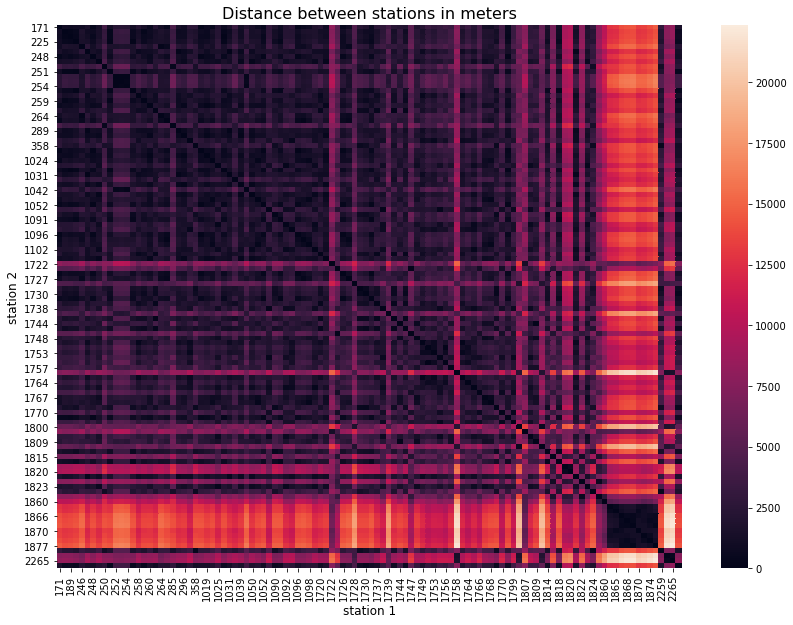

In [9]:
stations_df = (active_st_df[['start_station_id', 'start_station_name','start_station_latitude', 'start_station_longitude']]
            .drop_duplicates()
            .rename(columns={'start_station_id': 'id', 'start_station_latitude':'lat', 'start_station_longitude':'long'})
            .reset_index()
            .drop(([101,112,62]), axis='index') # cleaning rows with wrong latitude and longitude
            .drop('start_date', 1)
            .set_index('id')
            .sort_index()) 

stations_df['lat_r'] = np.radians(stations_df['lat'])
stations_df['long_r'] = np.radians(stations_df['long'])
dist = DistanceMetric.get_metric('haversine')
distance_df = pd.DataFrame(dist.pairwise(stations_df[['lat_r','long_r']].to_numpy())*6373*1000,  columns = stations_df.index, index= stations_df.index).round(2)

fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(distance_df, ax=ax)
ax.set_title('Distance between stations in meters', fontsize=16)
ax.set_xlabel('station 1', fontsize=12)
ax.set_ylabel('station 2', fontsize=12)
plt.show()

### Busiest, oversupplied and undersupplied stations

Top 10 busiest stations :
[ 265 1728 1024  183  259  358 1767 1824 1025  289]
Top 10 undersupplied stations :
[1824 1728  250  358  285  258 1818 1808 1763 1814]
Top 10 oversupplied stations :
[ 248 1767  247 1024 1096 1039  189  265 1798  259]


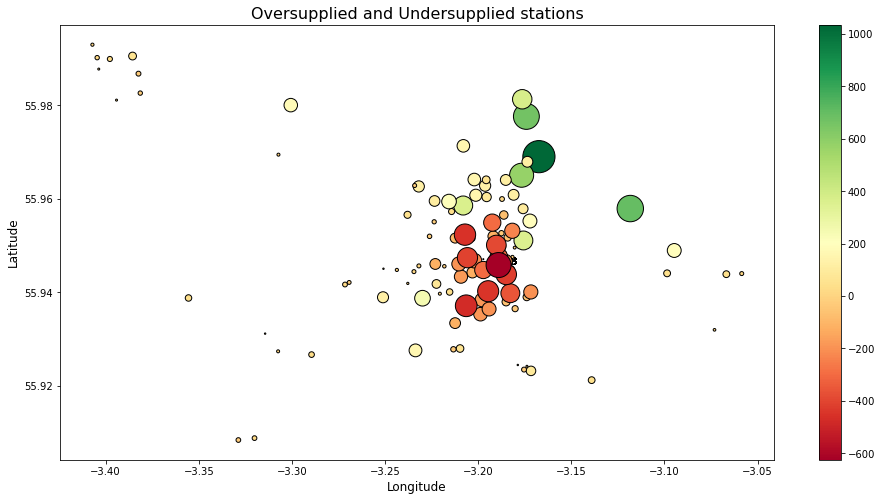

In [15]:
df = active_st_df[['start_station_id', 'start_station_name', 'end_station_id', 'start_station_latitude', 'start_station_longitude', 'count']].reset_index()

d1 = df.groupby('start_station_id').count()[['count']].rename(columns={'count':'count_start'})
df = d1.join(df.groupby('end_station_id').count()[['count']].rename(columns={'count':'count_end'}))
df = df.assign(supply = df['count_end'] - df['count_start'], count_sum = df['count_start'] + df['count_end'])
busiest = df.sort_values(['count_start'], ascending=False).head(10).index.values
supplied_df = df[['supply']].sort_values(['supply'], ascending=False).join(stations_df)

print(f"Top 10 busiest stations :\n{busiest}")
print(f"Top 10 undersupplied stations :\n{supplied_df.head(10).index.values}")
print(f"Top 10 oversupplied stations :\n{supplied_df.tail(10)[::-1].index.values}")

fig, ax = plt.subplots(figsize=(16,8))
supplied_df.plot.scatter('long', 'lat', ax=ax, cmap='RdYlGn', c=supplied_df['supply'], s=supplied_df['supply'].abs(),edgecolor='black', zorder=10)
ax.set_title('Oversupplied and Undersupplied stations', fontsize=16)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlabel('Longitude', fontsize=12)


for i in enumerate(supplied_df.index):
    ax.text(supplied_df.loc[id, 'long'], supplied_df.loc[id, 'lat'], id)
    

### Duration 

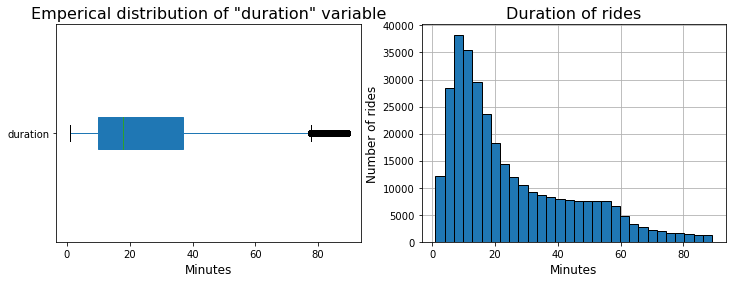

In [30]:
d = round(df1[['duration']]/60,2) # duration in minutes
Q1 = d.quantile(0.25)
Q3 = d.quantile(0.75)
IQR = Q3 - Q1

df = d[~((d < (Q1 - 1.5 * IQR)) |(d > (Q3 + 1.5 * IQR))).any(axis=1)]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
df.plot.box(ax=ax1, patch_artist=True, vert=False)
df.plot.hist(ax=ax2, bins=30, edgecolor = 'black', legend=None, grid=True, zorder=2 )
ax2.set_ylabel('Number of rides', fontsize=12)
ax2.set_title('Duration of rides', fontsize=16)
ax2.set_xlabel('Minutes', fontsize = 12)
ax1.set_xlabel('Minutes', fontsize = 12)
ax1.set_title(f'Emperical distribution of "duration" variable',fontsize=16)
plt.show()

### Demand analysis

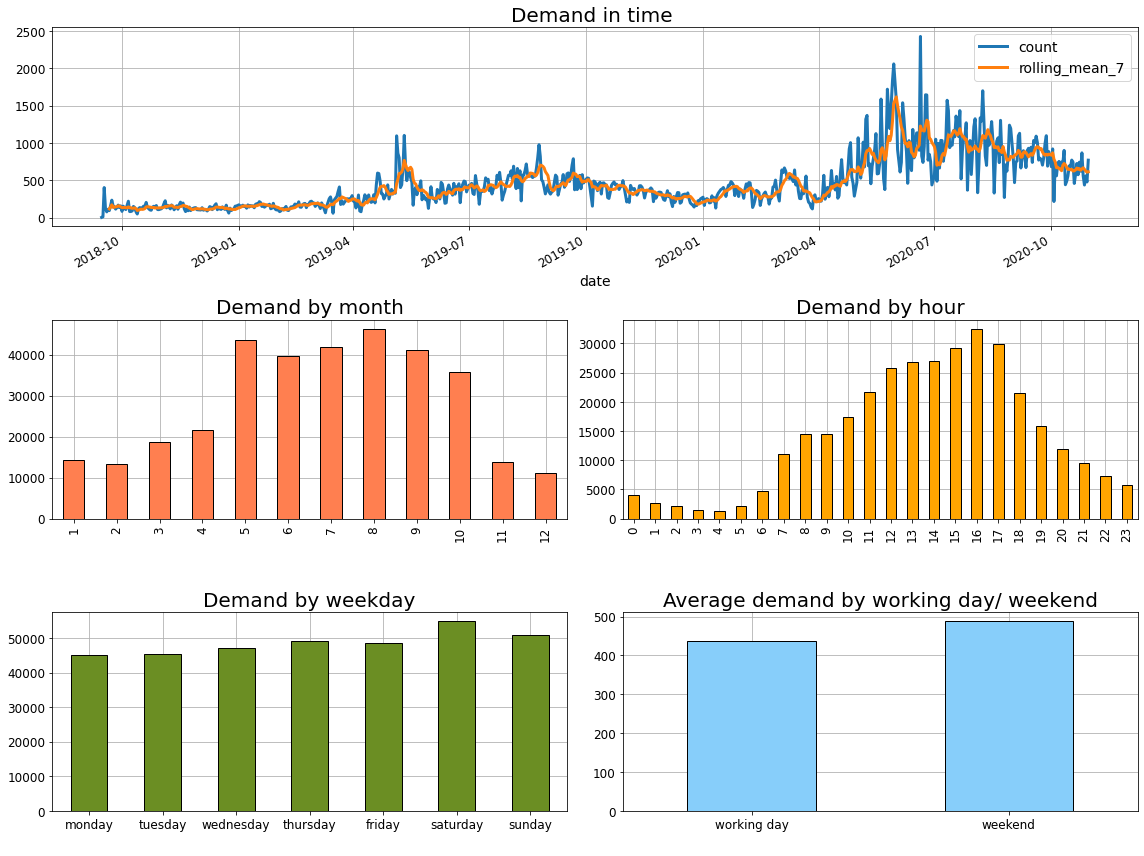

In [33]:
d = df1[['start_date', 'count', 'working_day','month','weekday','hour']].rename(columns={'start_date':'date'})
demand_df = d[['date', 'count']].groupby('date').sum()
demand_df['rolling_mean_7']= demand_df['count'].rolling(7).mean()
demand_df['weekend'] = ((pd.DatetimeIndex(demand_df.index).dayofweek) // 5 == 1).astype(int)
d2 = d[['month', 'count']].groupby('month').sum()
d3 = d[['weekday', 'count']].groupby('weekday').sum()
d4 = d[['hour', 'count']].groupby('hour').sum()
d5 = demand_df[['count', 'weekend']].groupby('weekend')[['count']].mean().round()
matplotlib_setup = {'figure': {'figsize': (16,12)}, 
                    'axes': {'titlesize': 20, 'labelsize': 14}, 
                    'xtick': {'labelsize': 12}, 
                    'ytick': {'labelsize': 12},
                    'legend': {'fontsize': 14, 'title_fontsize': 16}}
for obj, params in matplotlib_setup.items():
    plt.rc(obj, **params)
bar_kwargs = {'grid': True, 'edgecolor': 'black', 'legend': None, 'zorder':5, 'xlabel': ' '}
fig = plt.figure()
ax1 = plt.subplot2grid((3,2), (0,0), fig=fig, colspan=3)
ax2 = plt.subplot2grid((3,2), (1,0), fig=fig)
ax3 = plt.subplot2grid((3,2), (1,1), fig=fig)
ax4 = plt.subplot2grid((3,2), (2,0), fig=fig)
ax5 = plt.subplot2grid((3,2), (2,1), fig=fig)
demand_df[['count', 'rolling_mean_7']].plot(ax=ax1, title='Demand in time ', lw=3, grid=True, )
d2.plot.bar(ax=ax2, title= 'Demand by month', color = 'coral',**bar_kwargs)
d3.plot.bar(ax=ax4, title= 'Demand by weekday',color= 'olivedrab', **bar_kwargs)
d4.plot.bar(ax=ax3, title= 'Demand by hour', color = 'orange',  **bar_kwargs)
d5.plot.bar(ax=ax5, title='Average demand by working day/ weekend',color='lightskyblue', **bar_kwargs)
ax4.set_xticklabels(['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], rotation=0, ha='center')
ax5.set_xticklabels(['working day', 'weekend'], rotation=0)
plt.tight_layout()
plt.show()

#### Demand vs Weather

In [34]:
weather_df = pd.read_sql('select * from edinburgh_weather', alchemy_conn)

In [35]:
@np.vectorize
def adj_vis(val):
    if val == 'Excellent':
        return 0
    elif val == 'Good':
        return 1
    elif val == 'Average':
        return 2
    else:
        return 3

In [36]:
w_df = weather_df.copy()

w_df.iloc[:,1:-2] = w_df.iloc[:,1:-2].apply(lambda x: x.str.extract('(\d+)', expand=False))
w_df[w_df.columns[1:-2]] = w_df[w_df.columns[1:-2]].astype(int)
w_df['date'] = w_df['date'].astype('datetime64')
w_df['vis'] = adj_vis(w_df['vis'])
w_df = w_df.groupby('date').mean().join(demand_df['count']).dropna()
w_df.head()

,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,count
date,,,,,,,,,,
2018-09-15,10.500,8.500,14.875,23.500,0.125,83.875,58.125,1017.375,0.000,3.0
2018-09-16,12.875,10.625,26.500,43.125,0.000,81.500,79.500,1008.875,0.000,10.0
2018-09-17,13.875,13.125,18.000,29.875,0.000,83.000,66.125,1006.375,0.000,403.0
2018-09-18,14.125,13.500,16.875,28.500,0.125,86.875,57.750,996.125,0.000,126.0
2018-09-19,11.750,8.625,34.750,55.625,0.250,75.750,52.250,995.875,0.125,77.0


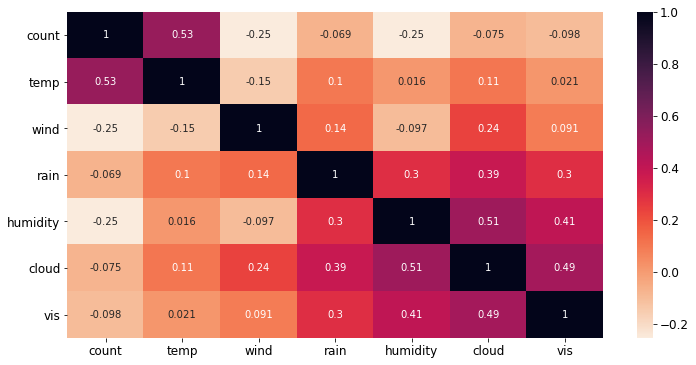

In [37]:
w_df_corrmat = w_df[['count', 'temp', 'wind', 'rain', 'humidity', 'cloud', 'vis']].corr()
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(w_df_corrmat, annot=True, cmap=sns.cm.rocket_r)
plt.show()

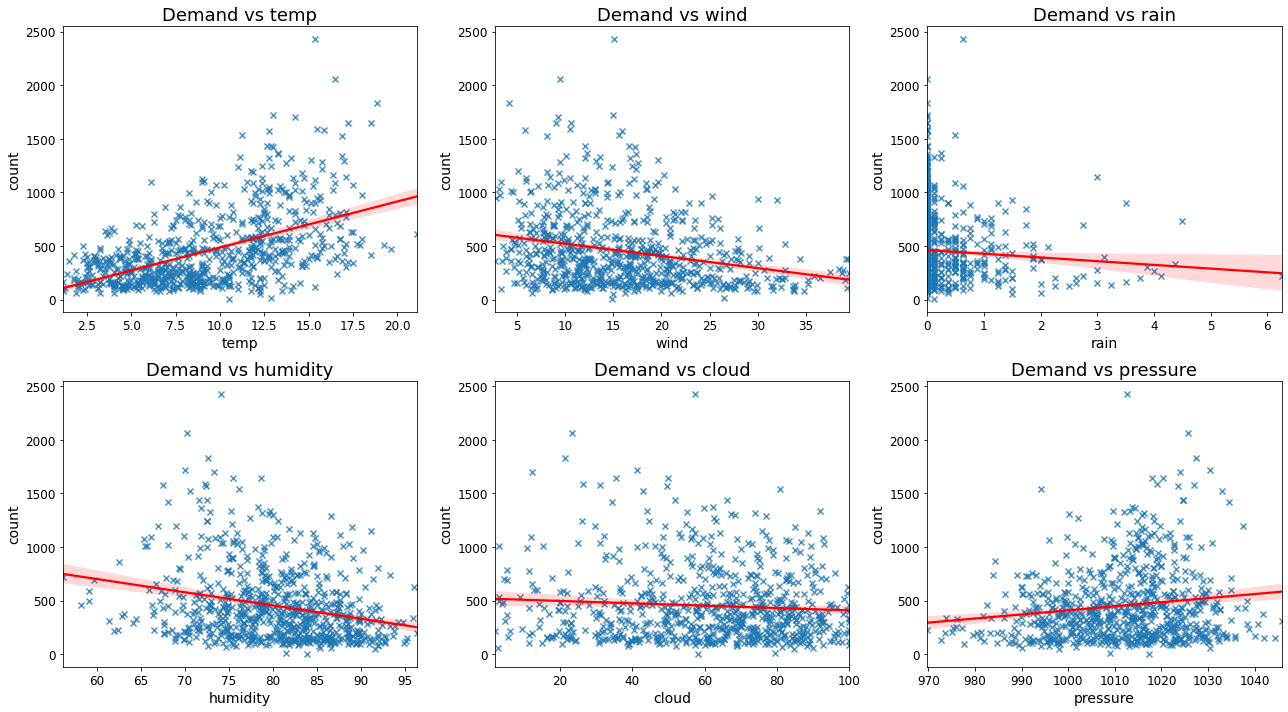

In [43]:
plt.figure(figsize=(18,10))
features = ['temp', 'wind', 'rain', 'humidity', 'cloud', 'pressure']
for i in enumerate(features):
    plt.subplot(2,3,i[0]+1)
    sns.regplot(x=i[1], y='count', data = w_df, marker='x', line_kws={"color": "red"})
    plt.title(f'Demand vs {i[1]}', fontsize=18)
plt.tight_layout()